Importy oraz stałe:

In [1]:
from typing import Tuple
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from scipy import interpolate

VOWELS_DIR = './vowels'

Pomocnicza klasa zawierająca jedynie metody statyczne, ma za zadanie wizualizować wykresy. 

In [2]:
class Visualizer:
    @staticmethod
    def visualize_spectrogram(signal: np.array) -> None:
        plt.figure()
        plt.specgram(signal, NFFT=4096, pad_to=3072)
        plt.title('Spectrogram')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_spectrum(freqs: np.array, spectrum: np.array, is_in_decibel: bool = False) -> None:
        plt.figure()
        plt.plot(freqs, spectrum)
        plt.title('Spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Level [dB]' if is_in_decibel else 'Amplitude')
        plt.show()
        plt.close()

    @staticmethod
    def visualize_signal(signal: np.array, points: np.array = None, is_in_decibel: bool = False) -> None:
        plt.figure()
        plt.plot(signal)

        if points is not None:
            plt.scatter(points[:, 0], points[:, 1], c='orange')

        plt.title('Signal with formants' if points is not None else 'Signal')
        plt.xlabel('Time [s]')
        plt.ylabel('Level [dB]' if is_in_decibel else 'Amplitude')
        plt.show()
        plt.close()

Funkcja monofonizująca sygnał, o ile jest to możliwe.

In [3]:
def monophonize(data: np.array) -> np.array:
    if len(data.shape) == 1:
        return data

    return data.sum(axis=1) / 2

Funkcja interpolująca sygnał co zadany krok.

In [4]:
def interpolate_signal(signal: np.array, max_range: int, step: int) -> Tuple:
    signal_ranged = signal[:max_range + step + 11]
    freqs_ranged = np.arange(signal.shape[0])[:max_range + step + 11]

    output = []
    input = []

    for i in range(len(signal_ranged) // step):
        input.append(freqs_ranged[i * step])
        output.append(np.mean(signal_ranged[i * step:(i + 1) * step]))

    interpolated = interpolate.interp1d(input, output)

    return freqs_ranged, interpolated(freqs_ranged[:max_range])

Prosta funkcja znajdująca wszystkie piki w sygnale. Wartości poniżej -50 dB nie są brane pod uwagę jako wzrosty.

In [5]:
def find_peaks(signal: np.array, first: bool = False) -> dict:
    peaks = {}

    for index in range(1, signal.shape[0] - 1):
        sample = signal[index]
        if sample < -50:
            continue

        prev_sample = signal[index - 1]
        next_sample = signal[index + 1]

        if sample > prev_sample and sample > next_sample:
            peaks[index] = sample

            if first:
                break

    if len(peaks) == 0:
        index = signal.shape[0] - 1
        peaks[index] = signal[index]

    return peaks

Funkcja automatycznie wyliczająca formanty. Piki są grupowane w obrębie 1000 Hz, a następnie wyliczana jest dla nich wartość średnia. Było przydatne dla testowania pliku z pojedynczą samogłoską.

In [6]:
def calc_formants(signal: np.array) -> dict:
    peaks = find_peaks(signal)
    keys = list(peaks.keys())

    formants = {}
    current_iter = 0

    while current_iter < len(peaks):
        current_freq = keys[current_iter]
        freqs = [current_freq]

        while current_iter < len(peaks) - 1:
            current_iter += 1
            freq = keys[current_iter]

            # groups will not be further away than 1000 Hz
            if freq > current_freq + 1000:
                current_iter -= 1
                break

            freqs.append(keys[current_iter])

        formant_index = int(np.mean(freqs))
        formants[formant_index] = signal[formant_index]
        current_iter += 1

    return formants

Funkcja wyliczająca autokorelację dla podanego sygnału.

In [7]:
def calc_auto_correlation(signal: np.array) -> np.array:
    result = np.correlate(signal, signal, mode='full')

    return result[len(result) // 2:]

Funkcja obliczająca częstotliwość podstawową f0 dla danego sygnału.

In [8]:
def calc_f0(signal: np.array, fs: int) -> int:
    auto_correlation = calc_auto_correlation(signal)
    k0 = list(find_peaks(auto_correlation, True).keys())[0]

    return fs / k0

Funkcja wyliczająca pasmo częstotliwościowe dla zadanej częstotliwości formantu. Odejmowane są -3dB od wartości znajdującej się w danej częstotliwości celem znalezienia punktów granicznych określających pasmo.

In [9]:
def find_bandwidth(signal: np.array, formant_freq: int) -> np.array:
    bandwidth = np.ones(2) * -1
    formant_amplitude = signal[formant_freq]
    searched_amplitude = formant_amplitude - 3
    changing_range = 500

    start_point = formant_freq - changing_range if formant_freq >= changing_range else 0
    end_point = formant_freq + changing_range if formant_freq <= signal.shape[0] - changing_range else signal.shape[0]

    for i in range(start_point, end_point):
        sample = signal[i]

        if bandwidth[0] == -1 and sample >= searched_amplitude:
            bandwidth[0] = i
            continue

        if bandwidth[0] != -1 and sample <= searched_amplitude:
            bandwidth[1] = i
            break

    return bandwidth[1] - bandwidth[0]

Funkcja wyliczjąca odpowiedzi częstotliwościowe dla podanych formantów. Wykorzystuje współczynnik alpha, jako stałą rezonansu.

In [10]:
def calc_frequency_response_for_formants(formants: dict, fs: int, alpha: float = 1.1) -> np.array:
    return np.array([1 / (1 - 2 * alpha * np.cos(2 * np.pi * freq / fs) + alpha ** 2) for freq in formants.keys()])

Funkcja wyznaczająca przefiltrowany sygnał na podstawie modelu rezonatora Klatta.
Funkcja wyznacza okres `t`, będący odwrotnością częstotliwości podstawowej `f0`.
Trzy pierwsze elementy są zawsze kopiowane do tablicy wyjściowej.
Dla każdego formantu wyznaczane jest jego pasmo, które jest później wykorzystywane do wyliczenia współczynników `a`, `b` oraz `c`.
Następnie wykorzystywany jest wzór 𝑦(𝑛)=𝐴𝑥(𝑛)+𝐵𝑦(𝑛−1)+𝐶𝑦(𝑛−2) w równoległym (akurat tutaj każdy element jako osobny element tablicy) modelu do wyznaczenia wyjścia.

In [20]:
def calc_filter(signal: np.array, formants: dict, f0: int):
    formants_bandwidth = np.array([find_bandwidth(signal, formant) for formant in formants])

    t = np.power(f0, -1)
    output = np.empty_like(signal)
    output[:3] = signal[:3]

    for sample_iter in range(2, signal.shape[0]):
        elements = np.empty(len(formants))

        for formant_iter, (formant_freq, formant_amplitude) in enumerate(formants.items()):
            formant_bandwidth = formants_bandwidth[formant_iter]

            c = -np.exp(-2 * np.pi * formant_bandwidth * t)
            b = 2 * np.exp(-np.pi * formant_bandwidth * t) * np.cos(2 * np.pi * formant_freq * t)
            a = 1 - b - c
            h = a * signal[sample_iter] + b * output[sample_iter - 1] + output[sample_iter - 2]

            elements[formant_iter] = h

        output[sample_iter] = np.sum(elements)

    return output

Wczytanie pliku dźwiękowego oraz jego monofonizacja. W tym przypadku zostało wykorzystane nagranie ze słowem "mama".

In [12]:
fs, a = wavfile.read(f'mama.wav')
a = monophonize(a)

Obliczenie widma dla sygnału oraz wizualizacja tego widma w skali decybelowej oraz spektrogramu.

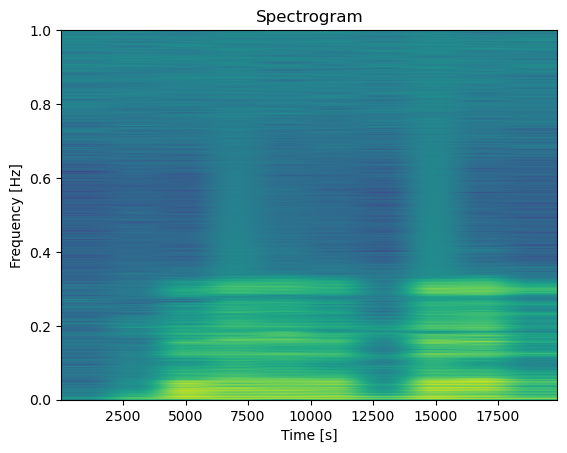

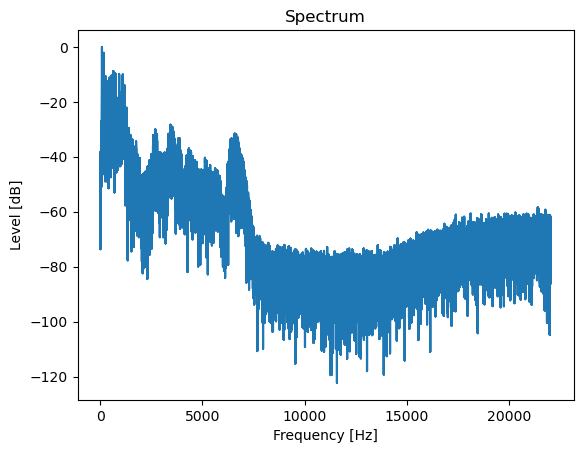

In [13]:
spectrum_freqs = np.abs(np.fft.fftfreq(a.shape[0], 1 / fs))
spectrum = np.abs(np.fft.fft(a))
spectrum_decibel = 20 * np.log10(spectrum / np.max(spectrum))

Visualizer.visualize_spectrogram(a)
Visualizer.visualize_spectrum(spectrum_freqs, spectrum_decibel, True)

Wykonanie interpolacji z krokiem co setna próbka oraz wizualizacja zinterpolowanego sygnału.

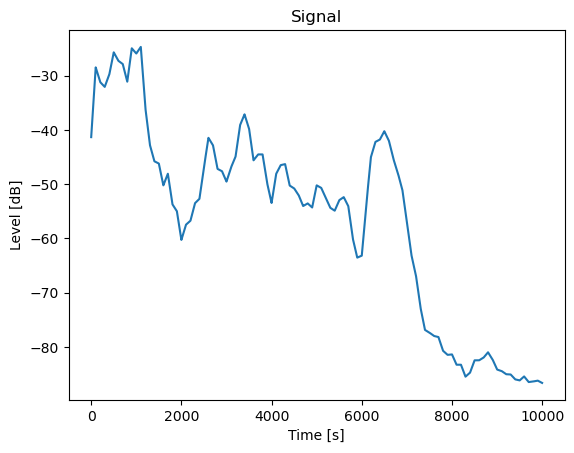

In [14]:
ranged_freqs, ranged_spectrum = interpolate_signal(spectrum_decibel, 10000, 100)
Visualizer.visualize_signal(ranged_spectrum, is_in_decibel=True)

Automatyczne obliczenie formantów dla zinterpolowanego sygnału oraz jego częstotliwości podstawowej i wypisanie ich na ekranie.

In [15]:
formants = calc_formants(ranged_spectrum)
print('Formants [Hz: dB]:\n', formants)

f0 = calc_f0(ranged_spectrum, fs)
print(f'Frequency f0: {f0}Hz')

Formants [Hz: dB]:
 {650: -27.575885497191074, 2150: -57.123070533508816, 3800: -44.52792464130416, 6500: -40.25234629438399}
Frequency f0: 4.41044104410441Hz


Wizualizacja sygnału zinterpolowanego z obliczonymi automatycznie formantami.

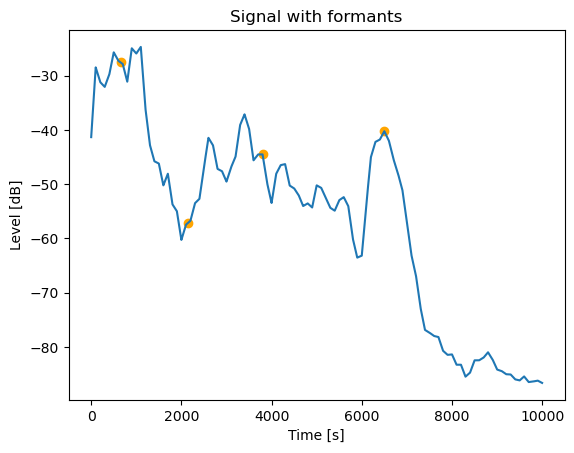

In [16]:
Visualizer.visualize_signal(ranged_spectrum, np.array([list(formants.keys()), list(formants.values())]).T, True)

Po zobrazowaniu jak zostały wyliczone automatycznie formanty, zdecydowałem się na zmianę dwóch środkowych formantów na jeden poprzez ręczne odczytanie z wykresu pików oraz ich uśrednienie w grupach lokalnych. 
Nowe formanty wraz z wizualizacją:

Formants [Hz: dB]:
 {650: -27.575885497191074, 3000: -49.52915153324454, 6500: -40.25234629438399}


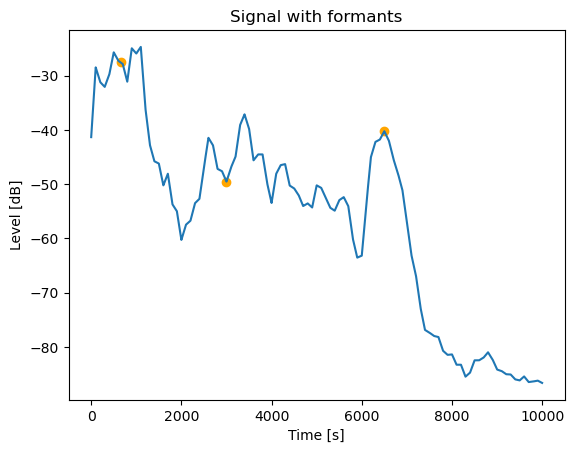

In [19]:
formants = {
    650: -27.575885497191074,
    3000: ranged_spectrum[3000],
    6500: -40.25234629438399,
}
print('Formants [Hz: dB]:\n', formants)
Visualizer.visualize_signal(ranged_spectrum, np.array([list(formants.keys()), list(formants.values())]).T, True)

Wyliczenie odpowiedzi częstotliwościowych dla każdego formantu.

In [17]:
frequency_reponse_formants = calc_frequency_response_for_formants(formants, fs)
print('Frequency responses for formants:\n', frequency_reponse_formants)

Frequency responses for formants:
 [51.47371444  8.89579711  3.08037641  1.12627176]


Wyznaczenie sygnału przefiltrowanego zgodnie z modelem Klatta, wypisanie rezultatu na ekran oraz prosta wizualizacja.

[-41.34303828 -41.21451717          nan ...          nan          nan
          nan]


C:\Users\Czarny\AppData\Local\Temp\ipykernel_3216\2646221748.py:14: RuntimeWarning: overflow encountered in exp
  c = -np.exp(-2 * np.pi * formant_bandwidth * t)
C:\Users\Czarny\AppData\Local\Temp\ipykernel_3216\2646221748.py:15: RuntimeWarning: overflow encountered in exp
  b = 2 * np.exp(-np.pi * formant_bandwidth * t) * np.cos(2 * np.pi * formant_freq * t)
C:\Users\Czarny\AppData\Local\Temp\ipykernel_3216\2646221748.py:16: RuntimeWarning: invalid value encountered in double_scalars
  a = 1 - b - c


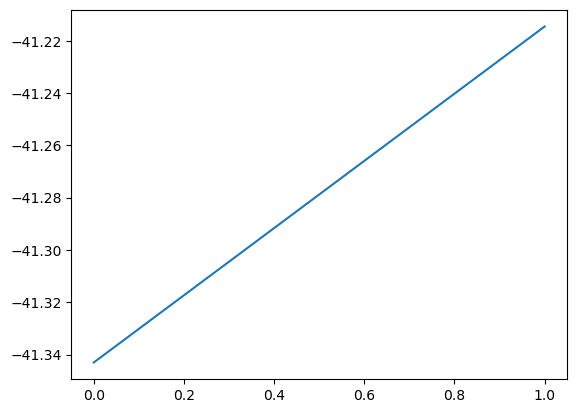

In [21]:
filtr = calc_filter(ranged_spectrum, formants, f0)
print(filtr)

plt.figure()
plt.plot(filtr)
plt.show()

Wnioski:
* Na spektrogramie wyraźnie widać momenty, w których wypowiadane są samogłoski `a`. Wizualizacja widma obrazuje już to znacznie mniej, w drugiej połowie wykresu jakby wszystko się ze sobą zrównało.
* Wybrałem krok co setny oraz zakres 10000, aby dobrze widoczne były piki sygnału, czyli podbicia charakterystyki.
* Po przeanalizowaniu automatycznie wyznaczonych formantów zmieniłem 2 środkowe w jeden, aby dokładniej oddać formant dla widocznego zgrupowania lokalnego.
* ...